In [15]:
# import system libs
import os
import time
import itertools

# import data handling tools
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, f1_score, recall_score
import plotly.express as px

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average, Dense, Concatenate
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [2]:
# Generate data paths with labels
def define_paths(data_dir):
    filepaths = []
    labels = []

    folders = os.listdir(data_dir)
    for folder in folders:
        folder_path = os.path.join(data_dir, folder)
        files = os.listdir(folder_path)
        for file in files:
            fpath = os.path.join(folder_path, file)
            filepaths.append(fpath)
            labels.append(folder)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Split dataframe to train, valid, and test
def split_data(data_dir):
    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # valid and test dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

In [3]:
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    datagen = ImageDataGenerator(preprocessing_function= None)

    train_gen = datagen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = datagen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    test_gen = datagen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= batch_size)

    return train_gen, valid_gen, test_gen

In [4]:
data_dir = './Pill Dataset'

try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(data_dir)

    # Get Generators
    batch_size = 40
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except:
    print('Invalid Input')

Found 16000 validated image filenames belonging to 10 classes.
Found 2000 validated image filenames belonging to 10 classes.
Found 2000 validated image filenames belonging to 10 classes.


In [5]:
# Load the saved base models
base_model1 = load_model("ResNet50_93.15.h5")
base_model2 = load_model("InceptionV3_96.15.h5")
base_model3 = load_model("MobileNet.h5")

In [6]:
base_model1 = Model(inputs=base_model1.inputs,
                outputs=base_model1.outputs,
                name='ResNet50')

base_model2 = Model(inputs=base_model2.inputs,
                outputs=base_model2.outputs,
                name='InceptionV3')

base_model3 = Model(inputs=base_model3.inputs,
                outputs=base_model3.outputs,
                name='MobileNet')

In [7]:
models = [base_model1, base_model2, base_model3]
model_input = Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='average_ensemble')

ensemble_model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

ensemble_model.summary()

Model: "average_ensemble"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 ResNet50 (Functional)          (None, 10)           23608202    ['input_1[0][0]']                
                                                                                                  
 InceptionV3 (Functional)       (None, 10)           21823274    ['input_1[0][0]']                
                                                                                                  
 MobileNet (Functional)         (None, 10)           3239114     ['input_1[0][0]'] 

In [8]:
batch_size = 32  # set batch size for training
epochs = 10  # number of all epochs in training

# Define ReduceLROnPlateau callback
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# Record start time
start_time = time.time()

# Fit the stacking ensemble on the base model predictions
history = ensemble_model.fit(x=train_gen, epochs=epochs, batch_size=batch_size,
                    validation_data=valid_gen, shuffle=True,
                    callbacks=[lr_callback])
                    
# Record end time
end_time = time.time()

# Calculate training duration
training_duration = end_time - start_time
print(f"Training duration: {training_duration} seconds")

Epoch 1/10
400/400 [==============================] - 9038s 23s/step - loss: 0.1782 - accuracy: 0.9613 - val_loss: 0.2370 - val_accuracy: 0.9555 - lr: 0.0010
Epoch 2/10
400/400 [==============================] - 9021s 23s/step - loss: 0.1188 - accuracy: 0.9783 - val_loss: 0.1720 - val_accuracy: 0.9645 - lr: 0.0010
Epoch 3/10
400/400 [==============================] - 9032s 23s/step - loss: 0.1095 - accuracy: 0.9808 - val_loss: 0.2139 - val_accuracy: 0.9670 - lr: 0.0010
Epoch 4/10
400/400 [==============================] - 8980s 22s/step - loss: 0.0976 - accuracy: 0.9846 - val_loss: 0.1357 - val_accuracy: 0.9715 - lr: 0.0010
Epoch 5/10
400/400 [==============================] - 9078s 23s/step - loss: 0.0797 - accuracy: 0.9879 - val_loss: 0.0992 - val_accuracy: 0.9770 - lr: 0.0010
Epoch 6/10
400/400 [==============================] - 8896s 22s/step - loss: 0.0570 - accuracy: 0.9896 - val_loss: 0.0730 - val_accuracy: 0.9770 - lr: 0.0010
Epoch 7/10
400/400 [==============================] 

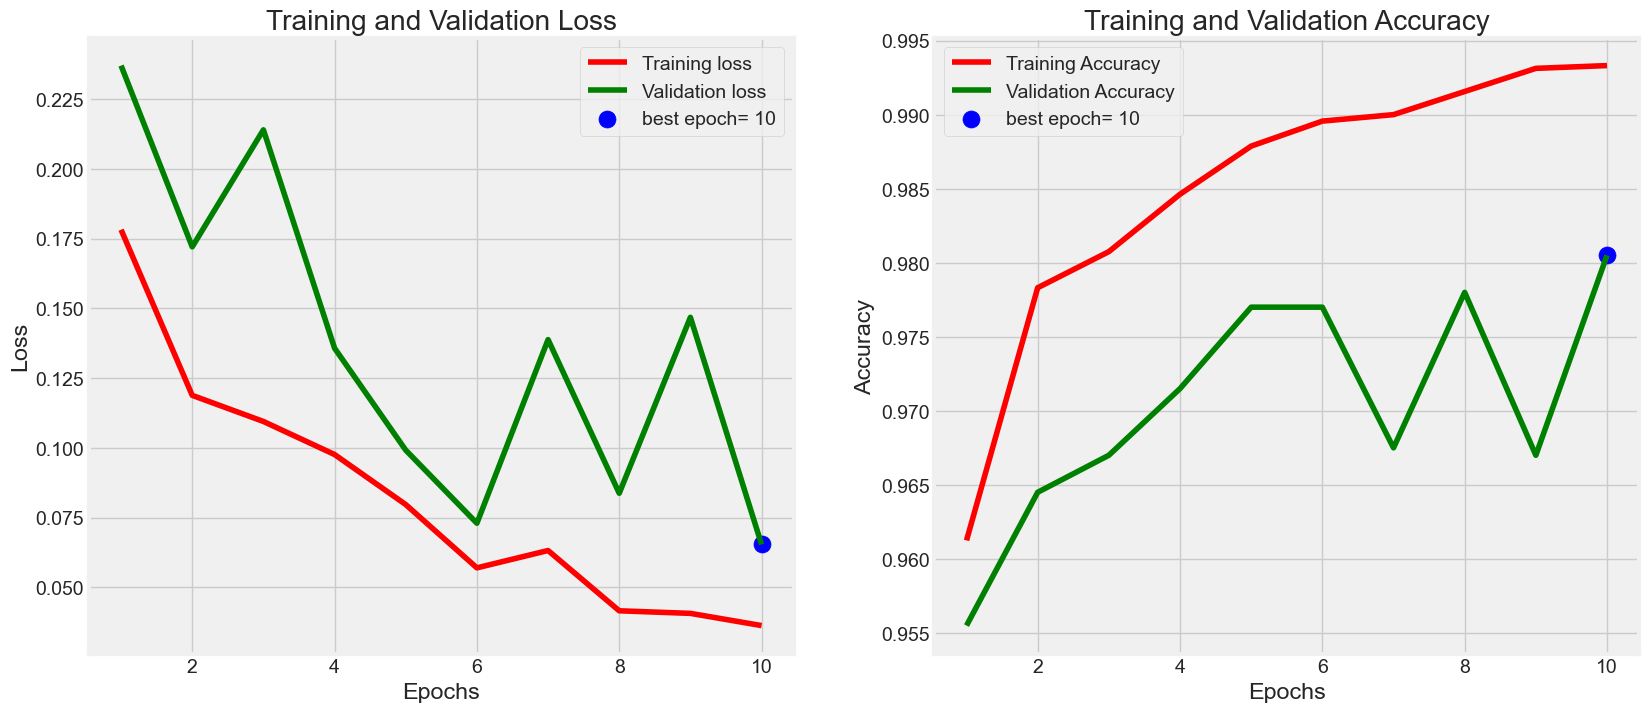

In [9]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()
    
plot_training(history)

In [10]:
train_eval = ensemble_model.evaluate(train_gen, verbose= 1)
valid_eval = ensemble_model.evaluate(valid_gen, verbose= 1)
test_eval = ensemble_model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_eval[0])
print("Train Accuracy: ", train_eval[1])
print('-' * 20)
print("Validation Loss: ", valid_eval[0])
print("Validation Accuracy: ", valid_eval[1])
print('-' * 20)
print("Test Loss: ", test_eval[0])
print("Test Accuracy: ", test_eval[1])

50/50 [==============================] - 252s 5s/step - loss: 0.0668 - accuracy: 0.9810
Train Loss:  0.027168316766619682
Train Accuracy:  0.9961249828338623
--------------------
Validation Loss:  0.06538345664739609
Validation Accuracy:  0.9804999828338623
--------------------
Test Loss:  0.06680157035589218
Test Accuracy:  0.9810000061988831


In [11]:
preds = ensemble_model.predict_generator(test_gen)
y_pred_class = np.argmax(preds, axis=1)
print(y_pred_class)

[1 6 8 ... 4 4 2]


In [12]:
print(test_gen.classes)

[1, 6, 8, 2, 0, 8, 7, 7, 4, 5, 7, 7, 7, 2, 7, 6, 1, 9, 6, 2, 8, 4, 3, 7, 4, 3, 8, 3, 9, 2, 3, 1, 1, 1, 6, 6, 1, 3, 8, 0, 5, 8, 1, 0, 5, 1, 7, 4, 8, 8, 5, 7, 9, 7, 4, 4, 7, 9, 2, 1, 0, 9, 9, 5, 3, 3, 1, 8, 9, 0, 1, 2, 3, 0, 6, 2, 7, 4, 7, 8, 5, 5, 4, 4, 1, 2, 3, 1, 1, 9, 9, 7, 6, 0, 5, 2, 2, 3, 6, 8, 6, 4, 4, 3, 8, 0, 5, 4, 9, 6, 7, 4, 7, 0, 3, 6, 5, 1, 1, 9, 7, 4, 1, 1, 0, 6, 8, 3, 2, 1, 3, 5, 3, 6, 8, 0, 3, 0, 8, 0, 4, 1, 1, 1, 7, 5, 5, 4, 8, 0, 0, 1, 2, 5, 1, 6, 4, 1, 9, 6, 1, 9, 8, 2, 7, 7, 7, 7, 9, 5, 0, 8, 3, 7, 2, 3, 7, 8, 3, 3, 1, 4, 2, 7, 4, 9, 1, 0, 6, 1, 0, 7, 5, 5, 0, 8, 8, 2, 0, 1, 4, 1, 1, 2, 0, 2, 0, 2, 9, 7, 6, 1, 5, 8, 2, 6, 4, 8, 3, 8, 5, 1, 7, 7, 6, 7, 8, 3, 6, 6, 4, 5, 0, 4, 1, 7, 5, 6, 5, 4, 4, 8, 5, 6, 1, 2, 8, 3, 3, 0, 2, 0, 5, 7, 8, 1, 3, 2, 0, 1, 8, 7, 2, 5, 1, 6, 7, 5, 2, 9, 4, 2, 5, 9, 9, 4, 7, 2, 0, 3, 9, 8, 3, 2, 5, 1, 6, 2, 5, 0, 4, 7, 2, 2, 4, 7, 3, 3, 5, 0, 0, 7, 9, 2, 6, 5, 9, 3, 0, 7, 2, 7, 7, 4, 9, 2, 4, 4, 5, 1, 9, 9, 7, 6, 3, 7, 5, 0, 4, 2, 7, 1, 9, 

In [17]:
# Calculate precision
precision = precision_score(test_gen.classes, y_pred_class, average = 'weighted')
print(f"Precision Score = {precision}")

# Calculate recall
recall = recall_score(test_gen.classes, y_pred_class, average = 'weighted')
print(f"Recall Score = {recall}")

# Calculate F1-score
f1 = f1_score(test_gen.classes, y_pred_class, average = 'weighted')
print(f"F1 Score = {f1}")

Precision Score = 0.9814667667980306
Recall Score = 0.981
F1 Score = 0.98103190879605


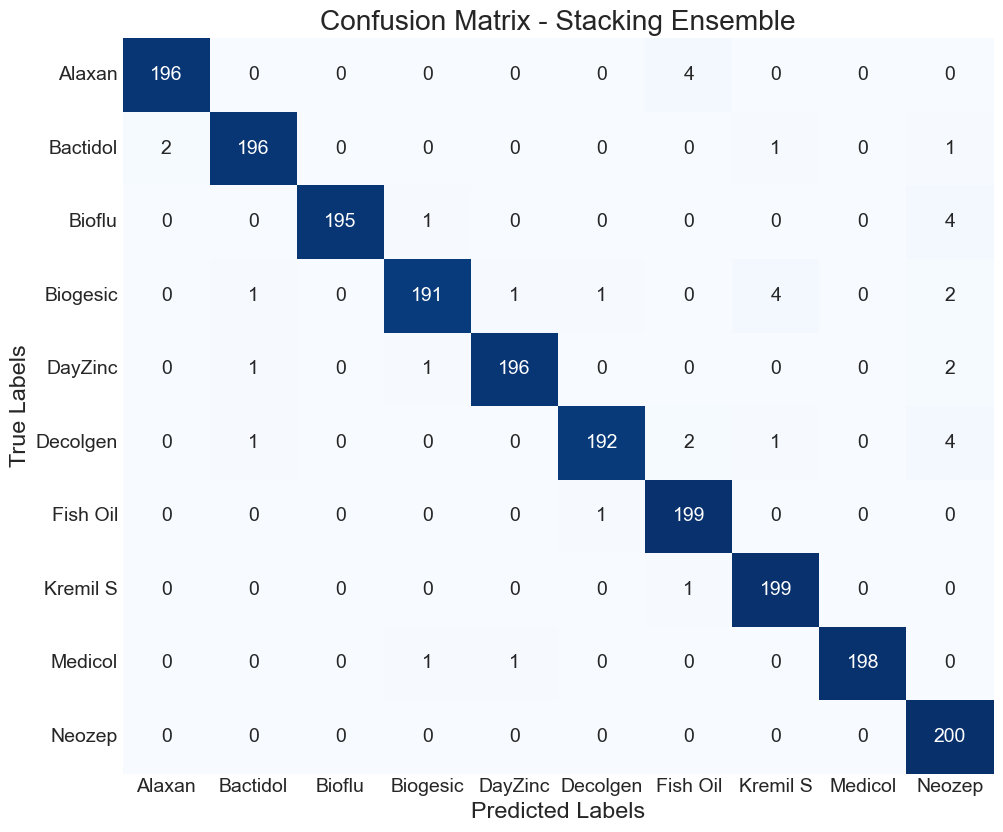

              precision    recall  f1-score   support

      Alaxan       0.99      0.98      0.98       200
    Bactidol       0.98      0.98      0.98       200
      Bioflu       1.00      0.97      0.99       200
    Biogesic       0.98      0.95      0.97       200
     DayZinc       0.99      0.98      0.98       200
    Decolgen       0.99      0.96      0.97       200
    Fish Oil       0.97      0.99      0.98       200
    Kremil S       0.97      0.99      0.98       200
     Medicol       1.00      0.99      0.99       200
      Neozep       0.94      1.00      0.97       200

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



In [18]:
class_dict = test_gen.class_indices
classes = list(class_dict.keys())

# Confusion matrix
conf_matrix = confusion_matrix(test_gen.classes, y_pred_class)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=test_gen.class_indices.keys(),
            yticklabels=test_gen.class_indices.keys())
plt.tight_layout()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Model Average Ensemble')
plt.show()

# Classification report
print(classification_report(test_gen.classes, y_pred_class, target_names= classes))

In [ ]:
#ensemble_model.save("Ensemble_Model.h5")